<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Predicting Shots Made Per Game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties — ridge, lasso, and elastic net — to try and predict how many shots Kobe Bryant made per game during his career.

The Kobe Shots data set contains hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model, considering the limited number of observations (games) we have available. Plus, many of the predictors have significant multicollinearity. 


**Warning:** Some of these calculations are computationally expensive and may take a while to execute. It may be worthwhile to only use a portion of the data to perform these calculations, especially if you've experienced kernel issues in the past.

---

### 1) Load packages and data.

In [2]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
kobe = pd.read_csv('../3_02-lab-cross_validation_regularization-regression/datasets/kobe_superwide_games.csv')

---

### 2) Examine the data.

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why might regularization be particularly useful for modeling this data?

In [4]:
len(kobe.columns)

645

In [5]:
kobe.describe()

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
count,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,...,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000
mean,7.358793,0.500642,0.001284,0.001284,0.000642,0.000642,0.001284,0.001284,0.000642,0.000642,...,0.000064,0.006207,0.002047,0.000032,0.014149,0.000050,0.000433,0.031766,42.946727,780.486521
std,3.471180,0.500160,0.035817,0.035817,0.025335,0.025335,0.035817,0.035817,0.025335,0.025335,...,0.001791,0.022033,0.011133,0.001267,0.041313,0.001390,0.004902,0.049402,26.048206,449.923227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,391.250000
50%,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,780.500000
75%,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,63.000000,1169.750000
max,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.050000,0.250000,0.133333,0.050000,0.533333,0.041667,0.111111,0.352941,105.000000,1559.000000


In [6]:
kobe.head(10)

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
5,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6
6,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,7
7,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,8
8,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,9
9,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,10


In [7]:
# Columns represents the statistics for each game played by Kobe e.g. Shots made in that game, whether it was a home or away game, season type/season year played, type of actions executed during the game etc
# Rows indicates the corresponding value of all the respective column for each game
# Regularization is particularly useful as the data has too many columns(predictive features) and of a similar essence e.g SEASON_OPPONENT:atl:1997-98 vs SEASON_OPPONENT:atl:1999-00

---

### 3) Create predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

## Standardizing predictors is required

In [8]:
y = kobe.SHOTS_MADE 
X = kobe.drop('SHOTS_MADE',axis=1) 
X.head()

,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,SEASON_OPPONENT:atl:2005-06,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5


# Create the target and predictor matrix

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [10]:
ss = StandardScaler()
ss.fit(X) 
X_scaled = ss.transform(X) 
X_scaled = pd.DataFrame(X_scaled,columns = X.columns) 
X_scaled.head()

,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,SEASON_OPPONENT:atl:2005-06,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,-1.001285,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,...,-0.035852,-0.281806,-0.183922,-0.025343,-0.342591,-0.035746,-0.088428,-0.643218,-1.610867,-1.733044
1,0.998717,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,...,-0.035852,-0.281806,-0.183922,-0.025343,-0.342591,-0.035746,-0.088428,-0.643218,-1.572464,-1.730821
2,0.998717,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,...,-0.035852,-0.281806,-0.183922,-0.025343,-0.342591,-0.035746,-0.088428,-0.643218,-1.534062,-1.728597
3,0.998717,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,...,-0.035852,-0.281806,-0.183922,-0.025343,-0.342591,-0.035746,-0.088428,-0.643218,-1.495659,-1.726374
4,-1.001285,27.892651,-0.035852,-0.025343,-0.025343,-0.035852,-0.035852,-0.025343,-0.025343,-0.035852,...,-0.035852,-0.281806,-0.183922,-0.025343,-0.342591,-0.035746,-0.088428,-0.643218,-1.457256,-1.724151


---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

In [11]:
lr = LinearRegression()
lr.fit(X_scaled, y) 
predictions = lr.predict(X_scaled) 
print(lr.score(X_scaled, y)) 

0.7788010891484558


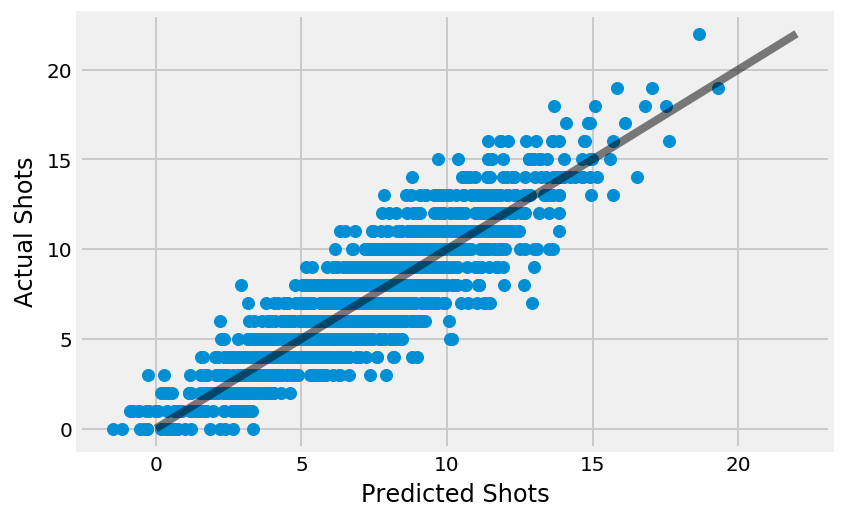

In [12]:
#Plot predicted vs actual values
plt.scatter(predictions, y);
plt.xlabel('Predicted Shots')
plt.ylabel('Actual Shots')
plt.plot([0,np.max(y)],[0,np.max(y)],c='k',alpha=0.5);

In [13]:
#Run cross validation, get R2 scores

In [14]:
scores = cross_val_score(lr, X_scaled, y, cv=10)

In [15]:
scores

array([-7.60323235e+28, -1.02384587e+28, -1.55254244e+28, -1.24868787e+28,
       -2.93829637e+28, -2.98279499e+27, -9.24958500e+27, -4.60754395e+27,
       -7.51445449e+27, -1.85534031e+28])

In [16]:
scores.mean()

-1.8657383063810897e+28

In [17]:
#The R-squared scores are very low indicating that the Cross-Validation Folds with linear regression does not fit well.

---

### 5) Find an optimal value for the ridge regression alpha using `RidgeCV`.

Go to the documentation and [read how RidgeCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

> *Hint: Once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that ridge performs best when searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit.


In [18]:
ridge_model = RidgeCV(alphas=np.logspace(0, 5, 200), store_cv_values=True)
ridge_model = ridge_model.fit(X_scaled, y) 
print(ridge_model.alpha_)

1742.6333860096508


---

### 6) Cross-validate the ridge regression $R^2$ with the optimal alpha.

Is it better than the linear regression? If so, why might this be?

In [19]:
ridge_model = Ridge(alpha=ridge_model.alpha_)
ridge_scores = cross_val_score(ridge_model, X_scaled, y, cv=5, scoring='r2') 
print(ridge_scores) 
print(ridge_scores.mean()) 

[0.60054093 0.55583502 0.5154279  0.45521193 0.50218328]
0.5258398115754532


---

### 7) Find an optimal value for lasso regression alpha using `LassoCV`.

Go to the documentation and [read how LassoCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). It is very similar to `RidgeCV`.

> *Hint: Again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that lasso, unlike ridge, performs best when searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide what alphas to use itself by setting the keyword argument `n_alphas=` to however many alphas you want it to search over. We recommend letting scikit-learn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if it's working, set `verbose =1`._

In [20]:
lasso_model = LassoCV(n_alphas = 500, cv=5, verbose =1) 
lasso_model = lasso_model.fit(X_scaled, y) 
print(lasso_model.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.05751220543165791


---

### 8) Cross-validate the lasso $R^2$ with the optimal alpha.

Is it better than the linear regression? Is it better than ridge? What do the differences in results imply about the issues with the data set?

In [21]:
lasso_model = Lasso(alpha=lasso_model.alpha_) #
lasso_scores= cross_val_score(lasso_model, X_scaled, y, cv=5, scoring='r2') 
print(lasso_scores)
print(lasso_scores.mean()) 

[0.69467352 0.58807754 0.55334933 0.49068518 0.53648795]
0.5726547022712358


---

### 9) Look at the coefficients for variables in the lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original data set are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** If you only fit the lasso within `cross_val_score`, you'll have to refit it outside of that function to pull out the coefficients.

In [22]:
lasso_model.fit(X_scaled,y) 
lasso_coefs = lasso_model.coef_ 

lasso_coefs_sorted = sorted(lasso_coefs, key=lambda lasso_coefs: np.abs(lasso_coefs),reverse=True) 
print(lasso_coefs_sorted)

[1.263288623569934, 0.8322346899752926, 0.4678223805384114, -0.28262822716992636, 0.2783668165097193, 0.13987014213876928, -0.13977402639813133, 0.13974630405527425, 0.1271313947284409, -0.12460361842809857, 0.12130900979838824, 0.11971316283945806, 0.1192819690548037, 0.10723546311593689, 0.10426824525570594, 0.10310665248468386, -0.10304697185876392, -0.09932223729245432, 0.09664680869554144, -0.08434590092256646, 0.08124632965232308, -0.0788154783899622, 0.07691222089402937, -0.07601490209622783, 0.0735691926150795, 0.07282022606983522, -0.06775880076469941, 0.06609151955784202, 0.06534062690977087, 0.06433272130193028, 0.06399308350507972, -0.06189825608591752, 0.06051795437247247, 0.0588343860580613, 0.05830748044775746, -0.0556322908332795, -0.05223961371439865, -0.05195478452159201, -0.05094335340465734, 0.05078815461013302, 0.049487095428199894, 0.047968967322277366, 0.04630875618842874, 0.04597772088644579, 0.045564898925422384, 0.04468678553654362, -0.04409517441631818, -0.04

In [23]:
lasso_model.get_params

<bound method BaseEstimator.get_params of Lasso(alpha=0.05751220543165791, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)>

In [24]:
zero_coefs = [i for i in lasso_coefs if i == 0] 
proportion_zero = len(zero_coefs)/len(lasso_coefs) 
proportion_zero

0.7391304347826086

In [25]:
# 10 most important predictors
get_index = [i for i in range(len(lasso_coefs)) if lasso_coefs[i] in lasso_coefs_sorted[:10]]
predictors_top10 = [col for col in X.columns if list(X.columns).index(col) in get_index]
predictors_top10

['SEASON_OPPONENT:mem:2009-10',
 'SEASON_OPPONENT:sac:1999-00',
 'SEASON:2015-16',
 'SHOT_ZONE_BASIC:restricted_area',
 'SHOT_TYPE:2pt_field_goal',
 'SHOT_TYPE:3pt_field_goal',
 'COMBINED_SHOT_TYPE:dunk',
 'COMBINED_SHOT_TYPE:jump_shot',
 'ACTION_TYPE:jump_shot',
 'ACTION_TYPE:layup_shot']

---

### 10) Find an optimal value for elastic net regression alpha using `ElasticNetCV`.

Go to the documentation and [read how ElasticNetCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note that here you'll be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: Strength of regularization.
- `l1_ratio`: Amount of ridge vs. lasso (0 = all ridge, 1 = all lasso).
    
Do not include 0 in the search for `l1_ratio` — it won't allow it and will break.

You can use `n_alphas` for the alpha parameters instead of setting your own values, which we highly recommend.

Also, be careful setting too many l1_ratios over cross-validation folds in your search. It can take a long time if you choose too many combinations and, for the most part, there are diminishing returns in this data.

In [35]:
enet_ratio = np.arange(0.01, 1.0, 0.01)
enet_model = ElasticNetCV(n_alphas=100, l1_ratio=enet_ratio, cv=5)
enet_model = enet_model.fit(X_scaled, y)
enet_model.alpha_

0.05770134237821771

In [27]:
enet_model.l1_ratio_

0.98

---

### 11) Cross-validate the elastic net $R^2$ with the optimal alpha and l1_ratio.
How does it compare to the ridge and lasso regularized regressions?

In [34]:
enet_model = ElasticNet(alpha=enet_model.alpha_,l1_ratio=enet_model.l1_ratio_) 
enet_scores = cross_val_score(enet_model, X_scaled, y, cv=5, scoring='r2') 
print(enet_scores.mean()) 

AttributeError: 'ElasticNet' object has no attribute 'alpha_'

---

### 12. [Bonus] Compare the residuals for ridge and lasso visually.


In [ ]:
# A: Maybe a jointplot?